In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [3]:
pipe.score(X_test, y_test)

0.972027972027972

## 在网格搜索中使用管道

我们要调节的两个参数 C 和 gamma 都是 SVC 的参数，属于第二个步骤。我们给这个步骤的名称是 "svm" 。
* 为管道定义参数网格的语法是为每个参数指定步骤名称，后面加上 __ （双下划线），然后是参数名称。因此，要想搜索 SVC 的 C 参数，必须使用 "svm__C" 作为参数网格字典的键，对 gamma 参数也是同理 

In [4]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [5]:
pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [6]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


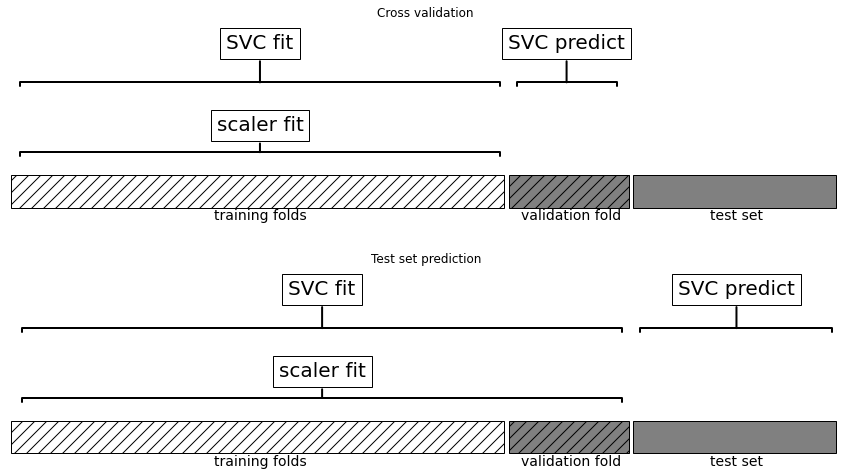

In [7]:
import mglearn
mglearn.plots.plot_proper_processing()

在交叉验证中，信息泄露的影响大小取决于预处理步骤的性质。使用测试部分来估计数据的范围，通常不会产生可怕的影响，但在特征提取和特征选择中使用测试部分，则会导致结果的显著差异。

## 举例说明信息泄露

In [8]:
import numpy as np
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [9]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)

print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


### 交叉验证计算得到的平均 R2 为 0.91，表示这是一个非常好的模型。这显然是不对的，因为我们的数据是完全随机的。这里的特征选择从 10 000 个随机特征中（碰巧）选出了与目标相关性非常好的一些特征。由于我们在交叉验证之外 对特征选择进行拟合，所以它能够找到在训练部分和测试部分都相关的特征。从测试部分泄露出去的信息包含的信息量非常大，导致得到非常不切实际的结果。我们将这个结果与正确的交叉验证（使用管道）进行对比

In [11]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
         np.mean(cross_val_score(pipe, X, y, cv=5))))


Cross-validation accuracy (pipeline): -0.25
